In [145]:
# Quantum
import pennylane as qml

# Numericlal
import math
import numpy as np
import sympy as sp

# Torch
import torch
import torch.nn as nn
from torch import optim
from torch.nn import MSELoss
from torch.utils.data import TensorDataset, DataLoader, random_split

# Trainer
from trainer import trainer

# Plot
import matplotlib.pyplot as plt

import torch
from torchviz import make_dot

%matplotlib inline



---

### Lemma 1

In [146]:
class Lemma1:
    '''
        QAF 논문 Lemma 1을 구현하기 위한 class
    '''
    def __init__(self, w, x, b):
        '''
            w(list) : list for weight
            x(list) : list for x(input)
            b(float) : float value of bias
        '''
        # list Initiallize
        self.w_list = w
        self.x_list = x
        self.b = b

        # vector Initiallize
        self.x = np.array(self.x_list)
        self.w = np.array(self.w_list)

        # lengths Calculate
        self.N_in = len(x)
        self.N = int(2 ** (np.ceil(np.log2(self.N_in + 3))))
        self.n = int(np.log2(self.N))

        # A_x, A_wb Calculate
        self.A_x  = np.sqrt(self.N_in - (self.x @ self.x))
        self.A_wb = np.sqrt(self.N_in + 1 - (self.w @ self.w + self.b * self.b))

        # v_x, v_wb
        self.v_x  = [self.A_x]  + self.x_list + [1.0]       + ([0.0] * (self.N - self.N_in - 2))
        self.v_wb = [0.0]       + self.w_list + [self.b]    + ([0.0] * (self.N - self.N_in - 3)) + [self.A_wb]

        # device initiallize
        # n : num_qubit
        self.dev = qml.device("default.qubit", wires=self.n)

    def norm(self, vec):
        return np.linalg.norm(vec)

    def u(self, vec):
        qml.AmplitudeEmbedding(vec, wires=range(self.n), normalize=True)

    def lemma1(self, chk=False):
        @qml.qnode(device=self.dev)
        def inner_lemma1():
            # U_x, i.e. small_u(v_x)
            self.u(self.v_x)

            # U_wb, i.e. small_u(v_wb)^†, Pauli-X for each qubit
            qml.adjoint(self.u)(self.v_wb)
            for i in range(self.n):
                qml.PauliX(wires=i)

            return qml.state()
        if chk:
            print(qml.draw_mpl(inner_lemma1)())
        return inner_lemma1()[-1]

---

### Theorem 1, Corollary 1

In [147]:
class Theorem1:
    '''
        QAF 논문 Theorem 1을 구현하기 위한 class
    '''
    def __init__(self, w, x, b, d, l = 0):
        '''
            w(list)     : list for weight
            x(list)     : list for x(input)
            b(float)    : float value of bias
            d(int)      : degree for Taylor (polynomial) Expansion
        '''
        # list Initiallize
        self.w_list = w
        self.x_list = x
        self.b = b
        self.d = d
        self.l = l

        # vector Initiallize
        self.x = np.array(self.x_list)
        self.w = np.array(self.w_list)

        # lengths Calculate
        self.N_in = len(x)
        self.N = int(2 ** (np.ceil(np.log2(self.N_in + 3))))
        self.n = int(np.log2(self.N))

        # A_x, A_wb Calculate
        self.A_x  = np.sqrt(self.N_in - (self.x @ self.x))
        self.A_wb = np.sqrt(self.N_in + 1 - (self.w @ self.w + self.b * self.b))

        # v_x, v_wb
        self.v_x  = [self.A_x]  + self.x_list + [1.0]       + ([0.0] * (self.N - self.N_in - 2))
        self.v_wb = [0.0]       + self.w_list + [self.b]    + ([0.0] * (self.N - self.N_in - 3)) + [self.A_wb]

        # device initiallize
        # n : num_qubit
        self.dev = qml.device("default.qubit", wires=(self.n + self.d + self.l))

    def U_z(self):
        qml.AmplitudeEmbedding(self.v_x, wires=range(self.n), normalize=True)
        qml.adjoint(qml.AmplitudeEmbedding)(self.v_wb, wires=range(self.n), normalize=True)
        for i in range(self.n):
            qml.PauliX(wires=i)

    def V(self, m):
        a_m = self.n + m

        # Controlled-Hadamard for (control, target) : (q register, a_m)
        qml.ctrl(qml.Hadamard, control=range(self.n))(wires=a_m)

        # CNOT for (control, target) : (a_m, q register)
        for i in range(self.n):
            qml.CNOT(wires=[a_m, i])

        # Controlled-U(x, w, b) for : (a_m, q register)
        qml.ctrl(self.U_z, control=a_m)()

    def outer_theorem1(self):
        '''
            Pauli-X 후 S_V(V_0, V_1, ... , V_{d-1})
        '''
        # Pauli-X for each qubit of q register
        for i in range(self.n):
            qml.PauliX(wires=i)

        # V_m for each m in (0, ... , d - 1)
        for m in range(self.d):
            self.V(m)

    def theorem1(self, chk=False):
        '''
            Theorem 1의 state |psi_z^d> 를 생성해서, state vector를 return
        '''
        @qml.qnode(device=self.dev)
        def inner_theorem1():
            self.outer_theorem1()
            return qml.state()

        if chk:
            print(qml.draw_mpl(inner_theorem1)())
        return inner_theorem1()

    def corollary1(self, k):
        '''
            k를 input으로 받아, |N-1>(q)|2^k - 1>(a) state에 대한 amplitude를 return
        '''
        result = self.theorem1()
        bitstring = ('1' * self.n) + ('0' * (self.d - k)) + ('1' * k)
        index = int(bitstring, 2)
        return result[index]

In [148]:
class test(nn.Module):
    '''
        qaf_layer, 즉 n-to-1 perceptron(wx+b)에서, w가 잘 업데이트 되는지 확인하기 위한 클래스
    '''
    def __init__(self, input_size):
        '''
            input_size(int) : w와 x의 size -> N_in
        '''
        super(test, self).__init__()

        self.weights = nn.Parameter(torch.rand(input_size, requires_grad=True))
        self.bias = nn.Parameter(torch.rand(1, requires_grad=True))
        self.N_in=4
        self.d=4
        self.l=1
        self.N = int(2 ** (np.ceil(np.log2(self.N_in + 3))))
        self.n = int(np.log2(self.N))
        self.activation = 'sin(z)'
        self.dev = qml.device("default.qubit", wires=(self.n + self.d + self.l))

    def U_z(self):
        print("U z" ,self.weights)
        qml.AmplitudeEmbedding(self.v_x, wires=range(self.n), normalize=True)
        qml.adjoint(qml.AmplitudeEmbedding)(self.v_wb, wires=range(self.n), normalize=True)
        # for i in range(self.n):
        #     qml.PauliX(wires=i)

    def V(self, m):
        print("V" ,self.weights)
        a_m = self.n + m
        # Controlled-Hadamard for (control, target) : (q register, a_m)
        qml.ctrl(qml.Hadamard, control=range(self.n))(wires=a_m)

        # CNOT for (control, target) : (a_m, q register)
        for i in range(self.n):
            qml.CNOT(wires=[a_m, i])

        # Controlled-U(x, w, b) for : (a_m, q register)
        qml.ctrl(self.U_z, control=a_m)()

    def outer_theorem1(self):
        '''
            Pauli-X 후 S_V(V_0, V_1, ... , V_{d-1})
        '''
        # Pauli-X for each qubit of q register
        for i in range(self.n):
            qml.PauliX(wires=i)

        # V_m for each m in (0, ... , d - 1)
        for m in range(self.d):
            self.V(m)
        print("outer_theorem1")


    def theorem1(self, chk=True):
        '''
            Theorem 1의 state |psi_z^d> 를 생성해서, state vector를 return
        '''
        @qml.qnode(device=self.dev, interface="torch")
        def inner_theorem1():
            self.U_z()
            # self.outer_theorem1()

            # obs = qml.PauliZ(0)
            return qml.probs()
        if chk:
            print(qml.draw_mpl(inner_theorem1)())
        return inner_theorem1()

    def forward(self, x):
        N_in = len(self.weights) # torch.tensor([len(self.weights)])
        self.A_x  = torch.sqrt(torch.tensor(self.N_in)- ( x @ x))
        self.A_wb = torch.sqrt(torch.tensor(self.N_in + 1) - (self.weights @ self.weights + self.bias * self.bias))
        self.v_x    = torch.cat((self.A_x.unsqueeze(0),  x, torch.tensor([1.0]), torch.tensor([0.0] * (self.N - self.N_in - 2))))               # [self.A_x]  + self.x_list + [1.0]       + ([0.0] * (self.N - self.N_in - 2))
        self.v_wb   = torch.cat((torch.tensor([0.0]), self.weights, self.bias, torch.tensor([0.0] * (self.N - self.N_in - 3)), self.A_wb))
        print(self.A_x)
        print(self.v_x)
        print(self.v_wb)
        print("Z :" ,self.v_x@self.v_wb)
        result=self.theorem1()[0]

        return result # @ temp


In [168]:
class test(nn.Module):
    '''
        qaf_layer, 즉 n-to-1 perceptron(wx+b)에서, w가 잘 업데이트 되는지 확인하기 위한 클래스
    '''
    def __init__(self, input_size):
        '''
            input_size(int) : w와 x의 size -> N_in
        '''
        super(test, self).__init__()

        self.weights = nn.Parameter(torch.tensor([0.1,0.1,0.1,0.1],requires_grad=True))
        self.dev = qml.device("default.qubit", wires=2)

    def forward(self, input, chk=False):
        @qml.qnode(self.dev, interface="torch")
        def inner_forward():
            qml.AmplitudeEmbedding(input, wires=[0, 1], normalize=True)
            qml.adjoint(qml.AmplitudeEmbedding)(self.weights, wires=[0, 1], normalize=True)
            return qml.probs()
        if chk:
            print(qml.draw_mpl(inner_forward)())
        return inner_forward()[0]

In [169]:
test1 = test(4)
x = torch.tensor([0.1,0.2,0.3,0.0])
res = test1(x)
# print("res : ",res)
res.backward()
print("grad==============:",test1.weights.grad)
# print(test1.weights)

grad==============: tensor([-1.0714,  1.0714,  3.2143, -3.2143])


In [100]:
dot =make_dot(res, params={"w":test1.weights,"bias":test1.bias})
dot.render('computation_graph', format='png', cleanup=True)  # 파일로 저장
dot.view()

'computation_graph.pdf'

In [116]:
test1 = test(4)
print(list(test1.parameters()))
op1 = optim.Adam(test1.parameters(), lr=0.01)
# op1.zero_grad()
res = test1(x)
print("res:",res)
res.backward()
print(test1.weights.grad)
op1.step()
print(list(test1.parameters()))

[Parameter containing:
tensor([0.7208, 0.6183, 0.5284, 0.4863], requires_grad=True), Parameter containing:
tensor([0.7563], requires_grad=True)]
tensor(1.9235)
tensor([1.9235, 0.1000, 0.2000, 0.3000, 0.4000, 1.0000, 0.0000, 0.0000])
tensor([0.0000, 0.7208, 0.6183, 0.5284, 0.4863, 0.7563, 0.0000, 1.7351],
       grad_fn=<CatBackward0>)
Z : tensor(1.3051, grad_fn=<DotBackward0>)
res: tensor(1.3051, grad_fn=<DotBackward0>)
tensor([0.1000, 0.2000, 0.3000, 0.4000])
[Parameter containing:
tensor([0.7108, 0.6083, 0.5184, 0.4763], requires_grad=True), Parameter containing:
tensor([0.7463], requires_grad=True)]


In [170]:
1e-9

1e-09

In [195]:
class Theorem1: # _for_torch:
    '''
        QAF 논문 Theorem 1을 구현하기 위한 class
    '''
    def __init__(self, w, x, b, d, l = 0):
        '''
            w(torch.tensor([]))     : list for weight
            x(torch.tensor([]))     : list for x(input)
            b(torch.tensor([]))    : float value of bias
            d(int)      : degree for Taylor (polynomial) Expansion
        '''

        # print('Before list Initiallize Init')
        # list Initiallize
        self.w = w
        self.x = x
        self.b = b
        self.d = d
        self.l = l

        # # vector Initiallize
        # self.x = np.array(self.x_list)
        # self.w = np.array(self.w_list)

        # print('Before lengths Calculate Init')
        # lengths Calculate
        self.N_in = len(self.x)
        self.N = int(2 ** (np.ceil(np.log2(self.N_in + 3))))
        self.n = int(np.log2(self.N))

        # print('Before A_x, A_wb Calculate Init')
        # A_x, A_wb Calculate
        self.A_x  = torch.sqrt(torch.tensor(self.N_in)- (self.x @ self.x))
        self.A_wb = torch.sqrt(torch.tensor(self.N_in + 1) - (self.w @ self.w + self.b * self.b))

        # print('Before v_x, v_wb Init')
        # v_x, v_wb
        self.v_x    = torch.cat((self.A_x.unsqueeze(0),  self.x, torch.tensor([1.0]), torch.tensor([1e-3] * (self.N - self.N_in - 2))))               # [self.A_x]  + self.x_list + [1.0]       + ([0.0] * (self.N - self.N_in - 2))
        self.v_wb   = torch.cat((torch.tensor([1e-3]), self.w, self.b, torch.tensor([1e-3] * (self.N - self.N_in - 3)), self.A_wb))   # [0.0]       + self.w_list + [self.b]    + ([0.0] * (self.N - self.N_in - 3)) + [self.A_wb]

        # device initiallize
        # n : num_qubit
        self.dev = qml.device("default.qubit", wires=(self.n + self.d + self.l))

    def U_z(self):
        qml.AmplitudeEmbedding(self.v_x, wires=range(self.n), normalize=True)
        qml.adjoint(qml.AmplitudeEmbedding)(self.v_wb, wires=range(self.n), normalize=True)
        for i in range(self.n):
            qml.PauliX(wires=i)

    def V(self, m):
        a_m = self.n + m

        # Controlled-Hadamard for (control, target) : (q register, a_m)
        qml.ctrl(qml.Hadamard, control=range(self.n))(wires=a_m)

        # CNOT for (control, target) : (a_m, q register)
        for i in range(self.n):
            qml.CNOT(wires=[a_m, i])

        # Controlled-U(x, w, b) for : (a_m, q register)
        qml.ctrl(self.U_z, control=a_m)()

    def outer_theorem1(self):
        '''
            Pauli-X 후 S_V(V_0, V_1, ... , V_{d-1})
        '''
        # Pauli-X for each qubit of q register
        for i in range(self.n):
            qml.PauliX(wires=i)

        # V_m for each m in (0, ... , d - 1)
        for m in range(self.d):
            self.V(m)

    def theorem1(self, chk=False):
        '''
            Theorem 1의 state |psi_z^d> 를 생성해서, state vector를 return
        '''
        @qml.qnode(device=self.dev, interface="torch")
        def inner_theorem1():
            self.outer_theorem1()
            return qml.state()

        if chk:
            print(qml.draw_mpl(inner_theorem1)())
        return inner_theorem1()

    def corollary1(self, k):
        '''
            k를 input으로 받아, |N-1>(q)|2^k - 1>(a) state에 대한 amplitude를 return
        '''
        result = self.theorem1()
        bitstring = ('1' * self.n) + ('0' * (self.d - k)) + ('1' * k)
        index = int(bitstring, 2)
        return result[index]

---

### Theorem 2

In [196]:
class Theorem2(Theorem1):
    def __init__(self, w, x, b, d, f, l = 0):
        '''
            w, x, b, d : same as Thm1
            f(str) : name of function which will be sympified
        '''

        # print('Before Thm1 Init')
        super().__init__(w, x, b, d, l=l)
        # print('After Thm1 Init')
        self.f = sp.sympify(f) # target f
        self.k = -1     # target f의 taylor expansion 중 계수가 0이 아닌 최저 차수
        self.C_d = 1    # f_d(z)와 실제 f(z)의 factoring constant
        self.theta_list = self.make_theta_list()


    def taylor_series_coefficients(self):
        # 심볼 정의
        z = sp.symbols('z')
        point = 0.0

        # 테일러 전개 계산
        taylor_expansion = sp.series(self.f, z, point, self.d + 1).removeO()

        # 계수 추출
        coeffs = [taylor_expansion.coeff(z, i) for i in range(self.d + 1)]
        return coeffs

    def make_theta_list(self):
        # Get Coeffs of Taylor (polynomial) Expansion of target f
        coefficients = self.taylor_series_coefficients()

        # Update k (target f의 taylor expansion 중 계수가 0이 아닌 최저 차수)
        for i in range(0, self.d + 1):
            if coefficients[i] != 0:
                self.k = i
                break

        theta_list = [0 for _ in range(self.d)]
        # target f = 0
        if self.k < 0:
            return theta_list

        # a_i = 0 for all i < k
        for i in range(self.k):
            theta_list[i] = -1 * math.pi / 2

        # a_k Initiallization
        theta_list[self.k] = math.atan(-1 * coefficients[self.k + 1] / coefficients[self.k])

        A = 1
        for i in range(self.k + 1, len(coefficients) - 1):
            A *= math.cos(theta_list[i - 1])
            theta_list[i] = math.atan(-1 * coefficients[i + 1] / coefficients[self.k] * A)

        # C_d update
        C_d = coefficients[self.k] # a_k
        for i in range(self.k, self.d):
            C_d /= math.cos(theta_list[i]) # 1/cos(theta)
        self.C_d = torch.tensor([float(C_d)])

        return theta_list

    def U(self, d):
        '''
            U_d Unitary for S_U iteration
        '''
        theta_list = self.theta_list # make_theta_list()
        for k in range(1, d):
            a_0 = self.n
            a_k = a_0 + k
            qml.ctrl(qml.RY, control=a_k, control_values=0)(2 * theta_list[k - 1], wires=a_0)
            qml.CNOT(wires=[a_0, a_k])

    def outer_theorem2(self):
        '''
            S_U := d register에는 U_d, q register에는 Pauli-X for each qubit
        '''
        # Pauli-X for each qubit of q register
        # and S_V
        self.outer_theorem1()

        qml.Barrier()

        # U_d
        self.U(self.d)

        qml.Barrier()

        # Pauli-X for each qubit of q register
        for i in range(self.n):
            qml.PauliX(wires=i)

    def theorem2(self, chk=False):
        @qml.qnode(device=self.dev, interface="torch")
        def inner_theorem2():
            self.outer_theorem2()
            return qml.state()
        if chk:
            print(qml.draw_mpl(self.outer_theorem2)())
        return inner_theorem2()

    def corollary2(self, k):
        '''
            as same as col 1,
            k를 input으로 받아, |N-1>(q)|2^k - 1>(a) state에 대한 amplitude를 return
        '''
        result = self.theorem2()
        bitstring = ('0' * self.n) + ('0' * (self.d - k)) + ('1' * k)
        index = int(bitstring, 2)
        return result[index] * self.C_d # * C_d


---

### Amplitude Estimation

In [197]:
class qaf_layer(Theorem2):
    def __init__(self, w, x, b, d, f):
        '''
            w, x, b, d : same as Thm1
            f(str) : name of function which will be sympified
        '''
        # print('Before Thm2 Init')
        super().__init__(w, x, b, d, f, l = 1)
        # print('After Thm2 Init')

        self.f = sp.sympify(f) # target f
        self.k = -1 # target f의 taylor expansion 중 계수가 0이 아닌 최저 차수
        self.theta_list = self.make_theta_list()

    def outer_controlled_theorem2(self):
        l_0 = self.n + self.d # index of l register

        qml.Hadamard(wires=[l_0]) # Hadamard for l register

        qml.Barrier()

        qml.ctrl(self.outer_theorem2, control=[l_0],work_wires=[range(self.n+self.d)])()

        qml.Barrier()

        qml.Hadamard(wires=[l_0]) # Hadamard for l register

    def controlled_theorem2(self):
        @qml.qnode(device=self.dev, interface="torch")
        def inner_controlled_theorem2():
            self.outer_controlled_theorem2()
            return qml.probs()
        # qml.draw_mpl(inner_controlled_theorem2,show_all_wires=True)()
        return inner_controlled_theorem2()

    def amplitude_estimation(self):
        result = self.controlled_theorem2()[0] # get P_0
        factorized_inner_product = torch.sqrt(4 * result) - 1
        inner_product = factorized_inner_product * (2 ** (self.d / 2))
        return inner_product

    def activation_estimation(self):
        result = self.amplitude_estimation()
        return result * self.C_d


---

### QAF Model

In [198]:
# list Initiallize
x_tensor = torch.tensor([0.1, -0.2, -0.3, -0.4])
w_tensor = torch.tensor([-0.8, 0.7, 0.9, 0.3])
b = torch.tensor([0.5])
d = 5
f = 'sin(z)'

args = [x_tensor, w_tensor, b, d, f]

N_in = len(x_tensor)
z = (np.array(x_tensor) @ np.array(x_tensor) + b) / (N_in + 1)

target_w = torch.tensor([-0.8, 0.7, 0.9, 0.3])
target_b = torch.tensor([0.5])
# 'f(wx+b) -> f(target_w * x + target_b)'

In [246]:
# 데이터 생성
num_data = 2  # 총 데이터 개수
batch_size = 1  # 배치 크기

x_data = torch.rand(4, num_data)  # (20000, 1) shape로 생성
y_data = target_w @ x_data + target_b  # sin 함수로 출력 생성 (20000, 1)
x_data = x_data.T
# 텐서 데이터셋 생성
dataset = TensorDataset(x_data, y_data)

# Train/Test set 분할 (80%/20% 비율)
train_size = int(0.8 * num_data)
test_size = num_data - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoader 생성
train_loader = train_dataset # DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = test_dataset # DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 배치 예시 출력
x_batch, y_batch = next(iter(train_loader))
print("Example batch x:", x_batch.shape)  # Expected: [128, 1]
print("Example batch y:", y_batch.shape)  # Expected: [128, 1]


Example batch x: torch.Size([4])
Example batch y: torch.Size([])


In [247]:
class qaf_model(nn.Module):
    '''
        qaf_layer, 즉 n-to-1 perceptron(wx+b)에서, w가 잘 업데이트 되는지 확인하기 위한 클래스
    '''
    def __init__(self, input_size):
        '''
            input_size(int) : w와 x의 size -> N_in
        '''
        super(qaf_model, self).__init__()

        self.weights = nn.Parameter(torch.rand(input_size, requires_grad=True))
        self.bias = nn.Parameter(torch.rand(1, requires_grad=True))
        self.activation = 'sin(z)'

    def forward(self, input, dim=4):
        q_layer = qaf_layer(w=self.weights, x=input, b=self.bias, d=dim, f=self.activation)
        return q_layer.activation_estimation() # .retain_grad()


In [256]:
q2 = qaf_model(4)
optimizer =optim.Adam(q2.parameters(), lr=0.0001)
loss_list =[]
for ephoch in range(200):
    for step, batch in enumerate(train_loader):
        optimizer.zero_grad()
        x_data, y_data= batch
        res =q2(x_data)
        loss = torch.abs(y_data-res)
        loss.backward()
        optimizer.step()
        print(f"step {step} loss :",loss)
        loss_list.append(loss)
# trainer1= trainer(q2,train_loader=train_loader,test_loader=test_loader)

step 0 loss : tensor([0.6503], grad_fn=<AbsBackward0>)
step 0 loss : tensor([0.6502], grad_fn=<AbsBackward0>)
step 0 loss : tensor([0.6502], grad_fn=<AbsBackward0>)
step 0 loss : tensor([0.6501], grad_fn=<AbsBackward0>)
step 0 loss : tensor([0.6500], grad_fn=<AbsBackward0>)
step 0 loss : tensor([0.6500], grad_fn=<AbsBackward0>)
step 0 loss : tensor([0.6499], grad_fn=<AbsBackward0>)
step 0 loss : tensor([0.6499], grad_fn=<AbsBackward0>)
step 0 loss : tensor([0.6498], grad_fn=<AbsBackward0>)
step 0 loss : tensor([0.6497], grad_fn=<AbsBackward0>)
step 0 loss : tensor([0.6497], grad_fn=<AbsBackward0>)
step 0 loss : tensor([0.6496], grad_fn=<AbsBackward0>)
step 0 loss : tensor([0.6495], grad_fn=<AbsBackward0>)
step 0 loss : tensor([0.6495], grad_fn=<AbsBackward0>)
step 0 loss : tensor([0.6494], grad_fn=<AbsBackward0>)
step 0 loss : tensor([0.6494], grad_fn=<AbsBackward0>)
step 0 loss : tensor([0.6493], grad_fn=<AbsBackward0>)
step 0 loss : tensor([0.6492], grad_fn=<AbsBackward0>)
step 0 los

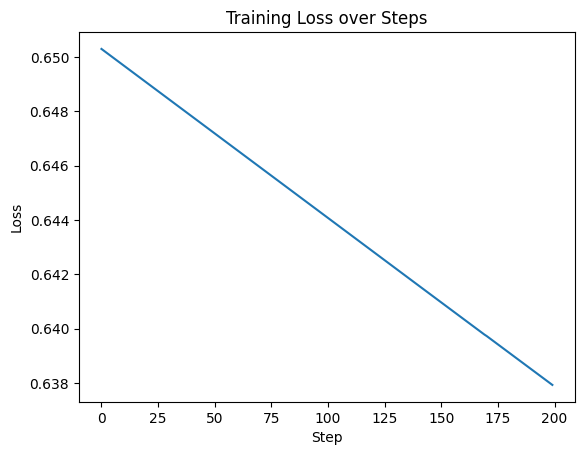

In [257]:
loss_list=[l.detach().numpy() for l in loss_list]
plt.plot(loss_list)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss over Steps')
plt.show()

In [206]:
trainer1.train()

  0%|          | 0/100 [00:00<?, ?it/s]/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrec

model weights grad :  tensor([-0.1463, -0.2067, -0.0842, -0.0730])
model weights grad :  tensor([-0.1050, -0.1899, -0.0686, -0.0298])
model weights grad :  tensor([-0.1052, -0.0325, -0.0381, -0.1134])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1430, -0.2068, -0.2714, -0.0763])
model weights grad :  tensor([-0.1096, -0.0704, -0.0372, -0.0842])
model weights grad :  tensor([-0.0877, -0.1778, -0.0416, -0.2875])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1353, -0.1160, -0.0785, -0.0064])
model weights grad :  tensor([-0.0791, -0.1938, -0.0961, -0.2290])
model weights grad :  tensor([-0.0287, -0.0375, -0.2111, -0.2433])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1488, -0.1088, -0.0774, -0.1160])
model weights grad :  tensor([-0.0202, -0.1964, -0.0144, -0.0100])
model weights grad :  tensor([-0.0311, -0.0076, -0.2281, -0.3462])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0657, -0.0246, -0.2468, -0.1885])
model weights grad :  tensor([-0.2256, -0.0930, -0.2713, -0.0923])
model weights grad :  tensor([-2.7038e-02, -1.9242e-02, -4.1510e-05, -8.6412e-03])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


model weights grad :  tensor([-0.1459, -0.0004, -0.1932, -0.1704])
model weights grad :  tensor([-0.0748, -0.0031, -0.1496, -0.0180])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1103, -0.5618, -0.5730, -0.5505])
model weights grad :  tensor([-0.0771, -0.0667, -0.0024, -0.0874])
model weights grad :  tensor([-0.0536, -0.1617, -0.0365, -0.1078])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1116, -0.0600, -0.1661, -0.1222])
model weights grad :  tensor([0.0149, 0.0008, 0.0040, 0.0096])
model weights grad :  tensor([-0.1581, -0.2930, -0.3126, -0.1987])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1887, -0.1340, -0.1275, -0.1201])
model weights grad :  tensor([-0.1589, -0.4181, -0.1646, -0.4189])
model weights grad :  tensor([-0.1178, -0.1198, -0.0069, -0.1040])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.2725, -0.2169, -0.2071, -0.2466])
model weights grad :  tensor([-0.1556, -0.3407, -0.2306, -0.3966])
model weights grad :  tensor([-0.0079, -0.4141, -0.3407, -0.1673])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0435, -0.2520, -0.1442, -0.1201])
model weights grad :  tensor([-0.0359, -0.1195, -0.1835, -0.0012])
model weights grad :  tensor([-0.0766, -0.2677, -0.0019, -0.1651])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0559, -0.0564, -0.3307, -0.1777])
model weights grad :  tensor([-0.0908, -0.1530, -0.0275, -0.0643])
model weights grad :  tensor([-0.2888, -0.3349, -0.2799, -0.3506])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.2160, -0.1678, -0.2250, -0.0377])
model weights grad :  tensor([-0.2611, -0.2693, -0.1531, -0.2537])
model weights grad :  tensor([-0.2127, -0.2722, -0.0876, -0.2644])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-3.9075e-03, -1.4585e-03, -9.1824e-05, -3.7062e-03])
model weights grad :  tensor([-0.0968, -0.0090, -0.2169, -0.0549])
model weights grad :  tensor([-0.2399, -0.3977, -0.3604, -0.0648])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1860, -0.0887, -0.2502, -0.1557])
model weights grad :  tensor([-0.2324, -0.2257, -0.2324, -0.1049])
model weights grad :  tensor([-0.2474, -0.2542, -0.3854, -0.2697])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.3039, -0.2332, -0.3337, -0.2845])
model weights grad :  tensor([-0.1048, -0.1006, -0.2473, -0.0362])
model weights grad :  tensor([-0.2532, -0.2267, -0.2575, -0.0017])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1825, -0.5155, -0.4419, -0.5089])
model weights grad :  tensor([-0.1392, -0.0244, -0.2382, -0.0896])
model weights grad :  tensor([0.0292, 0.0021, 0.0114, 0.0025])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0147, -0.4549, -0.1094, -0.4724])
model weights grad :  tensor([-0.1698, -0.1848, -0.0758, -0.1074])
model weights grad :  tensor([-0.0829, -0.0089, -0.1649, -0.2206])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1442, -0.0483, -0.1811, -0.0748])
model weights grad :  tensor([-0.1761, -0.2735, -0.3788, -0.3437])
model weights grad :  tensor([-0.0460, -0.0137, -0.0113, -0.0330])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1380, -0.0991, -0.0367, -0.1468])
model weights grad :  tensor([-0.1412, -0.0417, -0.1788, -0.2394])
model weights grad :  tensor([-0.1503, -0.4157, -0.2953, -0.0416])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0154, -0.1505, -0.2905, -0.3177])
model weights grad :  tensor([-0.1751, -0.0289, -0.1561, -0.1118])
model weights grad :  tensor([-0.1182, -0.1421, -0.0151, -0.0940])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1046, -0.0084, -0.0902, -0.2236])
model weights grad :  tensor([-0.1312, -0.1442, -0.0339, -0.0921])
model weights grad :  tensor([-0.1169, -0.2164, -0.1975, -0.0526])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1912, -0.1258, -0.1114, -0.2119])
model weights grad :  tensor([-0.2107, -0.3306, -0.2027, -0.3192])
model weights grad :  tensor([-0.1345, -0.1108, -0.1726, -0.0277])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1514, -0.0460, -0.1276, -0.1692])
model weights grad :  tensor([-0.0393, -0.2197, -0.1721, -0.0292])
model weights grad :  tensor([-5.6541e-02, -3.2554e-02, -7.7359e-05, -6.9595e-02])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1507, -0.2451, -0.1223, -0.0413])
model weights grad :  tensor([-0.0380, -0.0309, -0.0214, -0.0264])
model weights grad :  tensor([-0.0357, -0.0169, -0.3878, -0.4500])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


model weights grad :  tensor([-0.0344, -0.1180, -0.0800, -0.2538])
model weights grad :  tensor([-0.1717, -0.0571, -0.1748, -0.1012])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0726, -0.1641, -0.0905, -0.1222])
model weights grad :  tensor([-0.2937, -0.3711, -0.4094, -0.3285])
model weights grad :  tensor([-0.1140, -0.2774, -0.1057, -0.1421])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0765, -0.0492, -0.0317, -0.2053])
model weights grad :  tensor([-0.1526, -0.0036, -0.1819, -0.1054])
model weights grad :  tensor([-0.2456, -0.2701, -0.3531, -0.0825])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([0.0454, 0.0176, 0.0011, 0.0040])
model weights grad :  tensor([-0.0656, -0.4044, -0.1734, -0.4658])
model weights grad :  tensor([0.0060, 0.0017, 0.0018, 0.0012])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1518, -0.3045, -0.2028, -0.2196])
model weights grad :  tensor([-0.2141, -0.2719, -0.3544, -0.0157])
model weights grad :  tensor([-0.2919, -0.3516, -0.4048, -0.3845])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0726, -0.0739, -0.0044, -0.0337])
model weights grad :  tensor([-0.0587, -0.0430, -0.2625, -0.3280])
model weights grad :  tensor([-0.0956, -0.0025, -0.0906, -0.0051])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0643, -0.0148, -0.4377, -0.2434])
model weights grad :  tensor([-0.0622, -0.1030, -0.0232, -0.2623])
model weights grad :  tensor([-0.1459, -0.2678, -0.3080, -0.0203])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1522, -0.2480, -0.0453, -0.2062])
model weights grad :  tensor([-0.1553, -0.1123, -0.0939, -0.0884])
model weights grad :  tensor([-0.0365, -0.0135, -0.0075, -0.0134])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


model weights grad :  tensor([-0.2153, -0.2624, -0.4380, -0.3498])
model weights grad :  tensor([-0.1835, -0.1586, -0.0793, -0.1856])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1226, -0.1082, -0.0425, -0.0513])
model weights grad :  tensor([-7.0979e-05, -1.6727e-05, -2.8737e-06, -1.3046e-05])
model weights grad :  tensor([-0.1114, -0.0322, -0.0831, -0.0452])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0712, -0.1408, -0.1327, -0.0688])
model weights grad :  tensor([-0.1044, -0.1243, -0.0191, -0.0814])
model weights grad :  tensor([-0.0320, -0.0179, -0.0049, -0.0608])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0936, -0.2707, -0.0497, -0.1651])
model weights grad :  tensor([-0.0538, -0.0540, -0.1144, -0.2912])
model weights grad :  tensor([-0.1643, -0.3137, -0.2031, -0.1868])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1910, -0.0824, -0.3772, -0.3488])
model weights grad :  tensor([-0.1217, -0.1330, -0.0651, -0.2212])
model weights grad :  tensor([-0.2288, -0.0864, -0.2566, -0.2413])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1318, -0.1122, -0.0857, -0.0138])
model weights grad :  tensor([-0.0021, -0.0334, -0.0270, -0.0289])
model weights grad :  tensor([-0.0764, -0.1001, -0.0248, -0.0175])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1098, -0.2012, -0.2974, -0.2706])
model weights grad :  tensor([-0.1105, -0.0252, -0.1713, -0.0129])
model weights grad :  tensor([-0.0605, -0.0555, -0.0004, -0.0843])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0968, -0.2219, -0.1187, -0.1269])
model weights grad :  tensor([-0.1518, -0.2166, -0.2878, -0.4119])
model weights grad :  tensor([-0.1214, -0.1055, -0.0797, -0.0452])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([0.0195, 0.0013, 0.0051, 0.0099])
model weights grad :  tensor([-0.1379, -0.1119, -0.0590, -0.0791])
model weights grad :  tensor([-0.2344, -0.2765, -0.2241, -0.2511])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0779, -0.1358, -0.1904, -0.0560])
model weights grad :  tensor([-0.1984, -0.1116, -0.2013, -0.2036])
model weights grad :  tensor([-0.0907, -0.4620, -0.3294, -0.0294])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0018, -0.5227, -0.3337, -0.2667])
model weights grad :  tensor([-0.1107, -0.2818, -0.1964, -0.4120])
model weights grad :  tensor([-0.2897, -0.2646, -0.2813, -0.1674])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


model weights grad :  tensor([-0.1179, -0.0376, -0.0888, -0.1556])
model weights grad :  tensor([-0.0697, -0.0737, -0.0130, -0.1372])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0774, -0.0008, -0.1734, -0.2231])
model weights grad :  tensor([-0.2065, -0.3623, -0.4772, -0.3852])
model weights grad :  tensor([-0.2162, -0.1571, -0.2883, -0.1334])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0928, -0.1688, -0.1535, -0.1744])
model weights grad :  tensor([-0.0557, -0.1058, -0.0189, -0.0801])
model weights grad :  tensor([-0.1119, -0.1275, -0.0150, -0.1081])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0314, -0.0055, -0.0119, -0.0135])
model weights grad :  tensor([-0.1568, -0.1371, -0.1069, -0.0163])
model weights grad :  tensor([-0.1705, -0.0192, -0.2803, -0.1749])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0829, -0.1403, -0.0156, -0.1583])
model weights grad :  tensor([-0.0888, -0.0624, -0.1407, -0.2271])
model weights grad :  tensor([-0.2199, -0.3999, -0.4058, -0.4432])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0658, -0.1482, -0.0064, -0.2560])
model weights grad :  tensor([-0.1381, -0.0611, -0.3014, -0.2062])
model weights grad :  tensor([-0.0739, -0.0796, -0.1365, -0.2747])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0122, -0.0474, -0.1062, -0.0259])
model weights grad :  tensor([-0.0974, -0.2768, -0.4192, -0.2265])
model weights grad :  tensor([-0.1782, -0.3779, -0.3469, -0.3328])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0498, -0.0068, -0.0298, -0.0209])
model weights grad :  tensor([-0.0514, -0.0483, -0.0056, -0.0104])
model weights grad :  tensor([-0.1432, -0.2256, -0.3115, -0.4091])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0300, -0.0050, -0.0092, -0.0199])
model weights grad :  tensor([-0.2862, -0.2986, -0.2698, -0.2968])
model weights grad :  tensor([-0.1049, -0.1098, -0.0226, -0.0733])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0969, -0.1199, -0.0399, -0.1623])
model weights grad :  tensor([-0.0676, -0.2705, -0.0911, -0.2169])
model weights grad :  tensor([-0.0941, -0.0051, -0.0728, -0.0643])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0189, -0.3260, -0.2682, -0.0493])
model weights grad :  tensor([-0.0169, -0.2945, -0.0605, -0.1214])
model weights grad :  tensor([-0.2049, -0.1974, -0.1269, -0.1471])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1351, -0.0721, -0.1179, -0.0052])
model weights grad :  tensor([-0.0542, -0.0123, -0.0295, -0.0219])
model weights grad :  tensor([-0.0973, -0.1926, -0.2221, -0.1114])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0564, -0.0445, -0.1616, -0.2447])
model weights grad :  tensor([-0.0198, -0.1101, -0.0544, -0.0738])
model weights grad :  tensor([-0.0232, -0.0176, -0.1360, -0.1132])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0921, -0.3546, -0.2546, -0.3502])
model weights grad :  tensor([-0.0739, -0.1386, -0.2477, -0.3795])
model weights grad :  tensor([0.0183, 0.0038, 0.0002, 0.0046])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1844, -0.2881, -0.4189, -0.2972])
model weights grad :  tensor([-0.1262, -0.4005, -0.4046, -0.4617])
model weights grad :  tensor([-0.1219, -0.2098, -0.0406, -0.1006])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0766, -0.0945, -0.0168, -0.0128])
model weights grad :  tensor([-0.1019, -0.0635, -0.0621, -0.0470])
model weights grad :  tensor([-0.2292, -0.2059, -0.2726, -0.0779])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0950, -0.4144, -0.4540, -0.2930])
model weights grad :  tensor([-0.1015, -0.0749, -0.1515, -0.0663])
model weights grad :  tensor([-0.1948, -0.1262, -0.1743, -0.1019])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1582, -0.1623, -0.0951, -0.1061])
model weights grad :  tensor([-0.1382, -0.0496, -0.3148, -0.1031])
model weights grad :  tensor([-0.0266, -0.0105, -0.0121, -0.0040])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.2027, -0.3433, -0.2863, -0.0151])
model weights grad :  tensor([-0.0231, -0.2109, -0.4990, -0.0990])
model weights grad :  tensor([-0.1366, -0.0941, -0.1663, -0.2527])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0852, -0.1025, -0.0460, -0.0415])
model weights grad :  tensor([-0.0822, -0.1005, -0.0068, -0.0626])
model weights grad :  tensor([-0.0454, -0.1249, -0.1183, -0.1990])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.2303, -0.2335, -0.3268, -0.2764])
model weights grad :  tensor([-0.1239, -0.1377, -0.2139, -0.0230])
model weights grad :  tensor([-0.2241, -0.3721, -0.3912, -0.2340])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1788, -0.3511, -0.3154, -0.0207])
model weights grad :  tensor([-0.1001, -0.0293, -0.0657, -0.1225])
model weights grad :  tensor([-0.0574, -0.0088, -0.0289, -0.0463])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0708, -0.0283, -0.0228, -0.1227])
model weights grad :  tensor([-0.2278, -0.3453, -0.2878, -0.1580])
model weights grad :  tensor([-0.1589, -0.2214, -0.0739, -0.1447])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0878, -0.1964, -0.0202, -0.0544])
model weights grad :  tensor([-0.0526, -0.0449, -0.0002, -0.0435])
model weights grad :  tensor([-0.2594, -0.3457, -0.3838, -0.3465])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([0.0736, 0.0082, 0.0012, 0.0737])
model weights grad :  tensor([-0.2126, -0.3015, -0.2140, -0.1736])
model weights grad :  tensor([-0.1076, -0.0724, -0.0860, -0.0435])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


model weights grad :  tensor([-0.1694, -0.0913, -0.2302, -0.2650])
model weights grad :  tensor([-0.1019, -0.0389, -0.0635, -0.1134])
model weights grad :  tensor([-0.1608, -0.0744, -0.2029, -0.1515])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1195, -0.0848, -0.0804, -0.0015])
model weights grad :  tensor([-0.0769, -0.0233, -0.2408, -0.2325])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0692, -0.2302, -0.1823, -0.2398])
model weights grad :  tensor([-0.0447, -0.0400, -0.0018, -0.0215])
model weights grad :  tensor([-0.1608, -0.3134, -0.1811, -0.2128])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1041, -0.3106, -0.4441, -0.3282])
model weights grad :  tensor([-0.0178, -0.0054, -0.0028, -0.0146])
model weights grad :  tensor([-0.1609, -0.1714, -0.1854, -0.0846])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-2.7464e-02, -1.8783e-02,  8.6790e-06, -4.1951e-03])
model weights grad :  tensor([-0.0256, -0.0015, -0.0126, -0.0200])
model weights grad :  tensor([-0.2450, -0.2593, -0.2127, -0.2663])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0173, -0.2818, -0.0842, -0.1653])
model weights grad :  tensor([-0.0794, -0.1026, -0.0071, -0.1385])
model weights grad :  tensor([-0.0932, -0.1832, -0.0723, -0.1777])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1357, -0.1724, -0.1109, -0.0854])
model weights grad :  tensor([-0.2473, -0.2705, -0.2174, -0.2049])
model weights grad :  tensor([-0.2065, -0.1264, -0.2056, -0.0962])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0405, -0.1683, -0.0185, -0.0930])
model weights grad :  tensor([-0.1442, -0.0813, -0.2193, -0.1541])
model weights grad :  tensor([-0.1419, -0.1037, -0.0907, -0.0712])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0753, -0.0306, -0.0216, -0.1367])
model weights grad :  tensor([-0.0190, -0.2772, -0.1548, -0.1249])
model weights grad :  tensor([-0.1778, -0.1391, -0.1498, -0.0457])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


model weights grad :  tensor([-0.1477, -0.1730, -0.1124, -0.2209])
model weights grad :  tensor([-0.1097, -0.1753, -0.0323, -0.0793])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0969, -0.0572, -0.0718, -0.1583])
model weights grad :  tensor([-0.0568, -0.0563, -0.0021, -0.0358])
model weights grad :  tensor([-0.0132, -0.3090, -0.0076, -0.2565])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0560, -0.0417, -0.1731, -0.1180])
model weights grad :  tensor([-0.0775, -0.2967, -0.3413, -0.0950])
model weights grad :  tensor([-0.0316, -0.0244, -0.0078, -0.0051])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([0.0453, 0.0003, 0.0138, 0.0321])
model weights grad :  tensor([-0.1457, -0.0005, -0.1627, -0.1210])
model weights grad :  tensor([-0.0277, -0.1747, -0.0855, -0.3050])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1121, -0.0260, -0.0877, -0.0831])
model weights grad :  tensor([-0.1836, -0.1972, -0.2155, -0.0354])
model weights grad :  tensor([-0.1746, -0.2191, -0.1172, -0.1956])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0528, -0.0554, -0.0048, -0.0215])
model weights grad :  tensor([-0.1694, -0.1647, -0.1160, -0.1779])
model weights grad :  tensor([-0.2089, -0.3057, -0.2985, -0.0749])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1106, -0.0294, -0.1934, -0.0865])
model weights grad :  tensor([-0.0091, -0.0941, -0.0797, -0.0231])
model weights grad :  tensor([-0.1499, -0.2507, -0.1570, -0.1182])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0821, -0.1045, -0.0147, -0.0411])
model weights grad :  tensor([-0.1012, -0.0718, -0.1670, -0.0808])
model weights grad :  tensor([-0.1755, -0.1438, -0.2472, -0.1799])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1954, -0.1068, -0.2276, -0.2030])
model weights grad :  tensor([-0.1635, -0.0993, -0.1657, -0.0050])
model weights grad :  tensor([-0.1665, -0.1293, -0.1884, -0.0685])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0697, -0.0465, -0.0122, -0.0790])
model weights grad :  tensor([-0.0494, -0.0632, -0.0366, -0.0256])
model weights grad :  tensor([-0.1480, -0.1160, -0.1501, -0.0327])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0899, -0.0640, -0.1665, -0.0393])
model weights grad :  tensor([-0.1592, -0.0443, -0.1608, -0.0723])
model weights grad :  tensor([-0.1312, -0.3019, -0.3287, -0.3593])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0736, -0.0485, -0.0923, -0.0201])
model weights grad :  tensor([-0.0459, -0.1114, -0.0822, -0.2603])
model weights grad :  tensor([-0.2189, -0.2535, -0.2326, -0.0466])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1466, -0.2722, -0.1165, -0.1647])
model weights grad :  tensor([-0.0013, -0.0032, -0.0678, -0.2426])
model weights grad :  tensor([-0.1813, -0.1156, -0.2750, -0.2723])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0625, -0.3840, -0.3228, -0.1154])
model weights grad :  tensor([-0.1230, -0.0273, -0.2489, -0.1928])
model weights grad :  tensor([-0.1198, -0.1631, -0.0520, -0.1356])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1852, -0.1645, -0.2994, -0.1696])
model weights grad :  tensor([-0.1322, -0.1608, -0.1101, -0.2216])
model weights grad :  tensor([-0.1656, -0.0463, -0.2124, -0.0798])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0410, -0.0093, -0.1783, -0.0253])
model weights grad :  tensor([-0.0789, -0.2061, -0.1629, -0.1664])
model weights grad :  tensor([-0.1563, -0.1069, -0.1008, -0.1682])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1483, -0.0439, -0.1856, -0.1997])
model weights grad :  tensor([-0.0539, -0.0423, -0.0035, -0.0684])
model weights grad :  tensor([-0.0185, -0.0012, -0.0005, -0.0250])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0592, -0.0119, -0.0329, -0.0463])
model weights grad :  tensor([-0.0998, -0.4064, -0.2773, -0.3153])
model weights grad :  tensor([-0.0139, -0.0167, -0.3816, -0.0588])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0948, -0.0768, -0.0537, -0.0268])
model weights grad :  tensor([-0.2290, -0.2502, -0.2241, -0.1255])
model weights grad :  tensor([-0.0617, -0.1279, -0.0996, -0.1960])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1809, -0.1784, -0.1132, -0.1553])
model weights grad :  tensor([-0.0983, -0.0249, -0.1110, -0.0175])
model weights grad :  tensor([-0.0565, -0.0327, -0.0052, -0.0917])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1521, -0.0814, -0.2858, -0.2274])
model weights grad :  tensor([-0.0143, -0.2607, -0.2578, -0.0435])
model weights grad :  tensor([-0.0719, -0.1828, -0.1385, -0.1825])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0051, -0.3424, -0.0847, -0.2461])
model weights grad :  tensor([-0.0397, -0.0318, -0.0004, -0.0312])
model weights grad :  tensor([-0.0408, -0.0100, -0.0284, -0.0058])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0311, -0.0745, -0.0303, -0.0809])
model weights grad :  tensor([-0.1817, -0.3061, -0.2184, -0.0895])
model weights grad :  tensor([-0.1515, -0.2271, -0.2741, -0.3167])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1796, -0.1832, -0.1310, -0.0692])
model weights grad :  tensor([-0.1865, -0.2422, -0.2239, -0.0501])
model weights grad :  tensor([-0.1266, -0.0063, -0.2046, -0.1354])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0354, -0.1163, -0.0717, -0.0130])
model weights grad :  tensor([-0.1429, -0.2753, -0.2852, -0.0700])
model weights grad :  tensor([-0.1448, -0.1036, -0.2021, -0.0033])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0326, -0.0149, -0.0471, -0.0345])
model weights grad :  tensor([-0.0898, -0.2597, -0.0458, -0.1789])
model weights grad :  tensor([-0.1998, -0.1376, -0.2139, -0.1832])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0037, -0.1846, -0.0044, -0.0024])
model weights grad :  tensor([-0.0146, -0.1867, -0.4335, -0.3111])
model weights grad :  tensor([-0.0802, -0.1090, -0.0231, -0.0103])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([0.0134, 0.0009, 0.0015, 0.0089])
model weights grad :  tensor([-0.0705, -0.1564, -0.0292, -0.0153])
model weights grad :  tensor([-0.1142, -0.1704, -0.0567, -0.1683])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0386, -0.0185, -0.0159, -0.0199])
model weights grad :  tensor([-0.0530, -0.0495, -0.0086, -0.0261])
model weights grad :  tensor([-0.1327, -0.3002, -0.4313, -0.2744])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0494, -0.0137, -0.0240, -0.0617])
model weights grad :  tensor([-0.1211, -0.1033, -0.1680, -0.1427])
model weights grad :  tensor([-0.0222, -0.1176, -0.0076, -0.0094])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0697, -0.1300, -0.0091, -0.0224])
model weights grad :  tensor([-0.0388, -0.0083, -0.0129, -0.0507])
model weights grad :  tensor([-0.1420, -0.1542, -0.0731, -0.1295])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1973, -0.2437, -0.3046, -0.2748])
model weights grad :  tensor([-0.0733, -0.0011, -0.0779, -0.0023])
model weights grad :  tensor([-0.0422, -0.5116, -0.5345, -0.3950])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1519, -0.1449, -0.1199, -0.0030])
model weights grad :  tensor([-0.1211, -0.0164, -0.1114, -0.0825])
model weights grad :  tensor([-0.0704, -0.0015, -0.0568, -0.0449])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1429, -0.1404, -0.2366, -0.0703])
model weights grad :  tensor([-0.1035, -0.1141, -0.2592, -0.1110])
model weights grad :  tensor([-0.0532, -0.0028, -0.0231, -0.0815])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0909, -0.1391, -0.0107, -0.1494])
model weights grad :  tensor([-0.1075, -0.0390, -0.0836, -0.0703])
model weights grad :  tensor([-0.0641, -0.2655, -0.0603, -0.1813])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0625, -0.0542, -0.1387, -0.1382])
model weights grad :  tensor([-0.0914, -0.2056, -0.3238, -0.1502])
model weights grad :  tensor([-0.0170, -0.0038, -0.0022, -0.0135])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


model weights grad :  tensor([-0.0724, -0.1881, -0.0126, -0.1574])
model weights grad :  tensor([-0.1135, -0.1884, -0.0686, -0.0203])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


model weights grad :  tensor([-0.0837, -0.0222, -0.0604, -0.1274])
model weights grad :  tensor([-0.0611, -0.0978, -0.3631, -0.0123])
model weights grad :  tensor([-0.1474, -0.0527, -0.1286, -0.1709])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.2047, -0.2668, -0.3363, -0.1958])
model weights grad :  tensor([-0.1095, -0.0654, -0.1251, -0.2453])
model weights grad :  tensor([-0.0763, -0.0794, -0.3155, -0.1909])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0633, -0.3096, -0.1949, -0.1178])
model weights grad :  tensor([-0.0829, -0.0081, -0.0641, -0.0709])
model weights grad :  tensor([-0.0447, -0.0710, -0.2937, -0.3929])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1900, -0.1472, -0.2524, -0.1399])
model weights grad :  tensor([-0.0744, -0.0449, -0.0635, -0.1209])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1990, -0.1979, -0.1437, -0.2108])
model weights grad :  tensor([0.0233, 0.0073, 0.0047, 0.0046])
model weights grad :  tensor([-0.0601, -0.3761, -0.4347, -0.4577])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.1623, -0.3218, -0.2950, -0.3200])
model weights grad :  tensor([-0.0453, -0.0270, -0.0220, -0.0033])
model weights grad :  tensor([-0.0613, -0.0309, -0.0412, -0.0150])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please e

model weights grad :  tensor([-0.0706, -0.1202, -0.3786, -0.2482])
model weights grad :  tensor([-0.1038, -0.0391, -0.0970, -0.0743])
model weights grad :  tensor([-0.0626, -0.0169, -0.0354, -0.0657])


/Users/yuksehyun/anaconda3/envs/qrf/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/100 [00:33<?, ?it/s]


model weights grad :  tensor([-0.1843, -0.3066, -0.2733, -0.1036])


KeyboardInterrupt: 